In [ ]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import missingno as msno
import re
import os.path
import math
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from scipy import sparse
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score

import nltk
from wordcloud import WordCloud
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import unicodedata

from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('stopwords')
nltk.download('wordnet')

#plt.style.use('fivethirtyeight')
sns.set_style("whitegrid")
sns.set_context("talk", font_scale=0.8)



## Just for easy execution. Delete below later

# Read the data
preprocessed_data = False
if os.path.exists('Data/preprocessed/movies_genres_preprocessed.csv'):
    mydata = pd.read_csv('Data/preprocessed/movies_genres_preprocessed.csv')
    preprocessed_data = True
else:
    mydata = pd.read_csv('Data/movies_genres.csv', delimiter='\t')
    
category_columns = mydata.columns.drop(['title', 'plot', 'plot_lang'])
for col in category_columns:
    mydata[col] = mydata[col].astype('category')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ratho\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ratho\AppData\Roaming\nltk_data...


In [13]:
!pip install wordcloud


Defaulting to user installation because normal site-packages is not writeable


## Data Set Overview

**Load the data**

In [15]:
# Read the data
preprocessed_data = False
if os.path.exists('Data/preprocessed/movies_genres_preprocessed.csv'):
    mydata = pd.read_csv('Data/preprocessed/movies_genres_preprocessed.csv')
    preprocessed_data = True
else:
    mydata = pd.read_csv('Data/movies_genres.csv', delimiter='\t')

### Shape of the Data

In [16]:
print('Shape of data: ', mydata.shape)

Shape of data:  (117194, 30)


The provided data consists of over 117k observations of movies along with 30 column variables. Let us take a look into what each column looks like. 

### First Few Observations

In [17]:
pd.set_option('display.max_columns', 13)
mydata.head(2)

title  \
0                          "#7DaysLater" (2013)   
1  "#BlackLove" (2015) {Crash the Party (#1.9)}   

                                                plot  Action  Adult  \
0  dayslater interactive comedy series feature en...       0      0   
1  week leave workshops women consider idea ladie...       0      0   

   Adventure  Animation  ...  Sport  Talk-Show  Thriller  War  Western  \
0          0          0  ...      0          0         0    0        0   
1          0          0  ...      0          0         0    0        0   

   plot_lang  
0         en  
1         en  

[2 rows x 30 columns]

In [18]:
mydata.loc[1, 'title'], mydata.loc[1, 'plot']

('"#BlackLove" (2015) {Crash the Party (#1.9)}',
 'week leave workshops women consider idea ladies stun jahmil finally come decision bentley hes jack challenge tennesha express feel love towards errol put face possible rejection')

### Feature Data Types

In [19]:
mydata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117194 entries, 0 to 117193
Data columns (total 30 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   title        117194 non-null  object
 1   plot         117194 non-null  object
 2   Action       117194 non-null  int64 
 3   Adult        117194 non-null  int64 
 4   Adventure    117194 non-null  int64 
 5   Animation    117194 non-null  int64 
 6   Biography    117194 non-null  int64 
 7   Comedy       117194 non-null  int64 
 8   Crime        117194 non-null  int64 
 9   Documentary  117194 non-null  int64 
 10  Drama        117194 non-null  int64 
 11  Family       117194 non-null  int64 
 12  Fantasy      117194 non-null  int64 
 13  Game-Show    117194 non-null  int64 
 14  History      117194 non-null  int64 
 15  Horror       117194 non-null  int64 
 16  Music        117194 non-null  int64 
 17  Musical      117194 non-null  int64 
 18  Mystery      117194 non-null  int64 
 19  Ne

<Axes: >

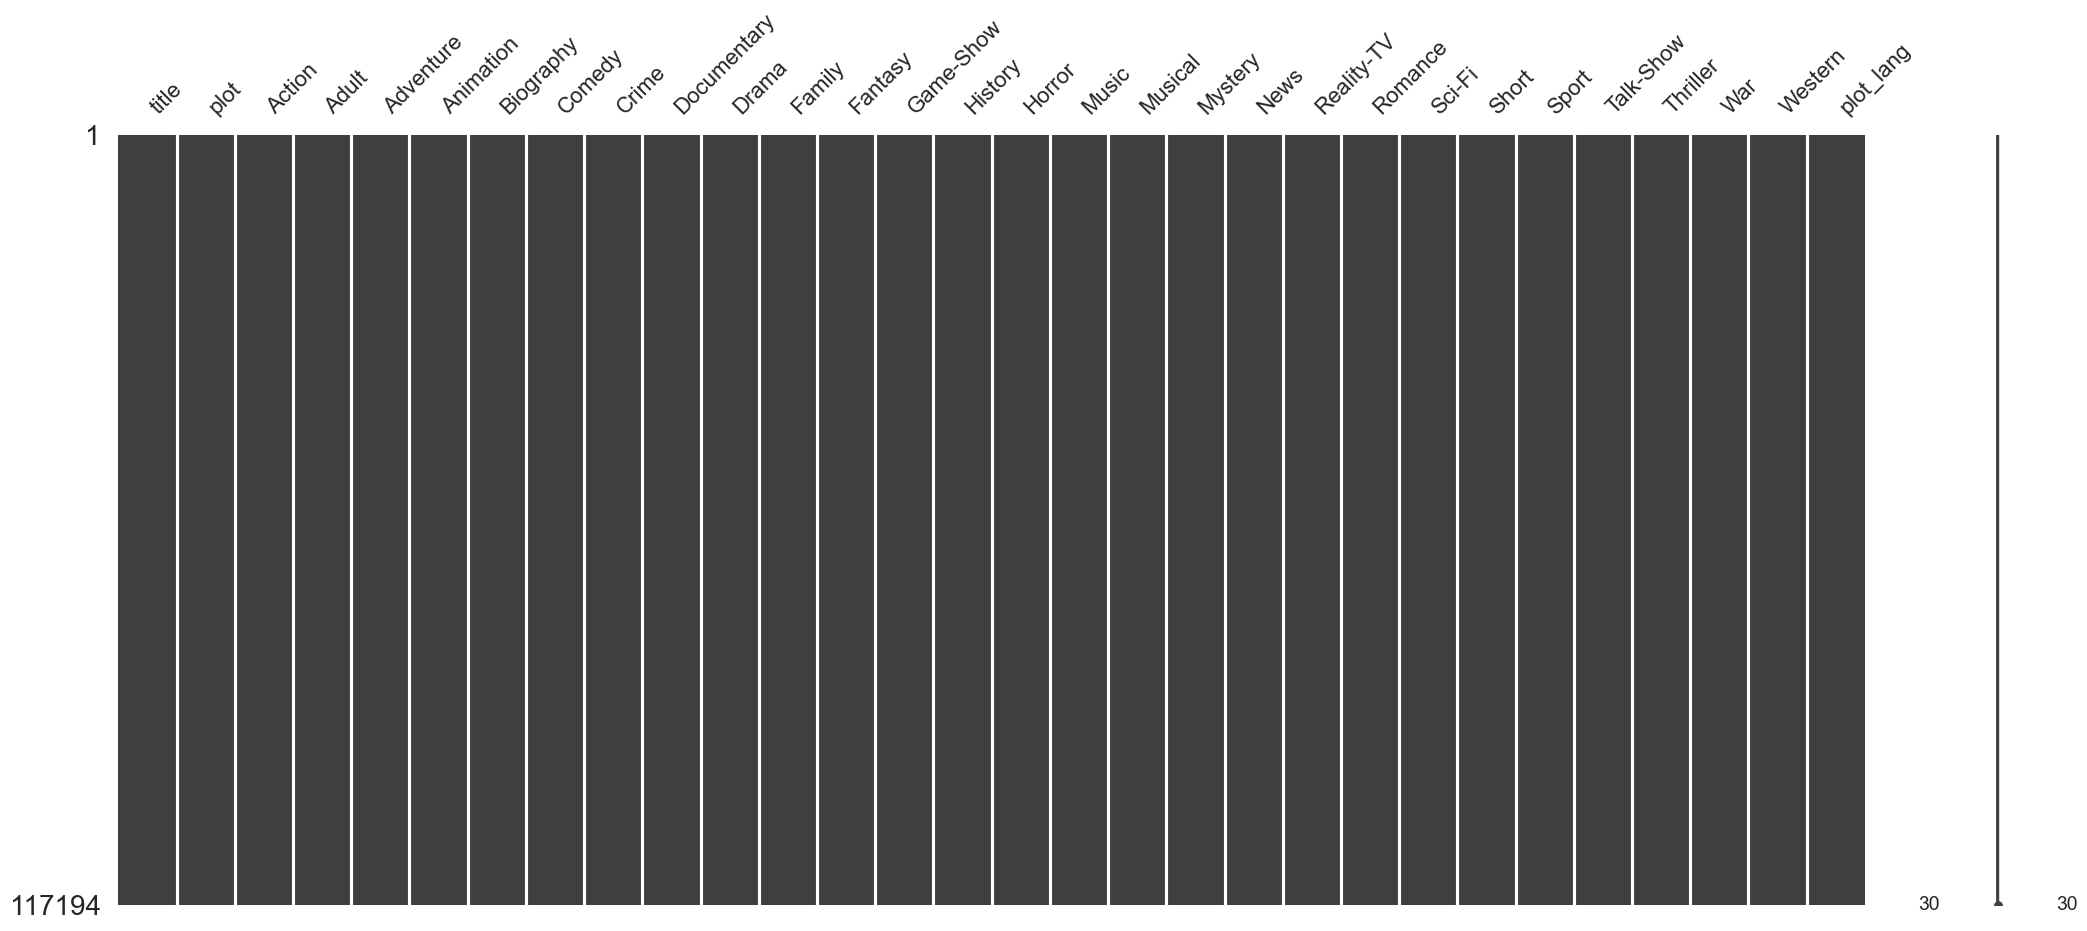

In [20]:
msno.matrix(mydata)

* There are no missing values
* All the Movie Genre columns have int data type. They have to be converted to categories.

# EDA

**Categorical Columns Conversion**  
Let us first convert all the genre feature set into categorical types

In [21]:
category_columns = mydata.columns.drop(['title', 'plot', 'plot_lang'])
for col in category_columns:
    mydata[col] = mydata[col].astype('category')

## Number of Movies per Genre

In [ ]:

sum_genre = mydata[category_columns].apply(pd.to_numeric, errors='coerce').sum()

df_movies_per_genre = pd.DataFrame({'Genre': category_columns, 'Total': sum_genre})


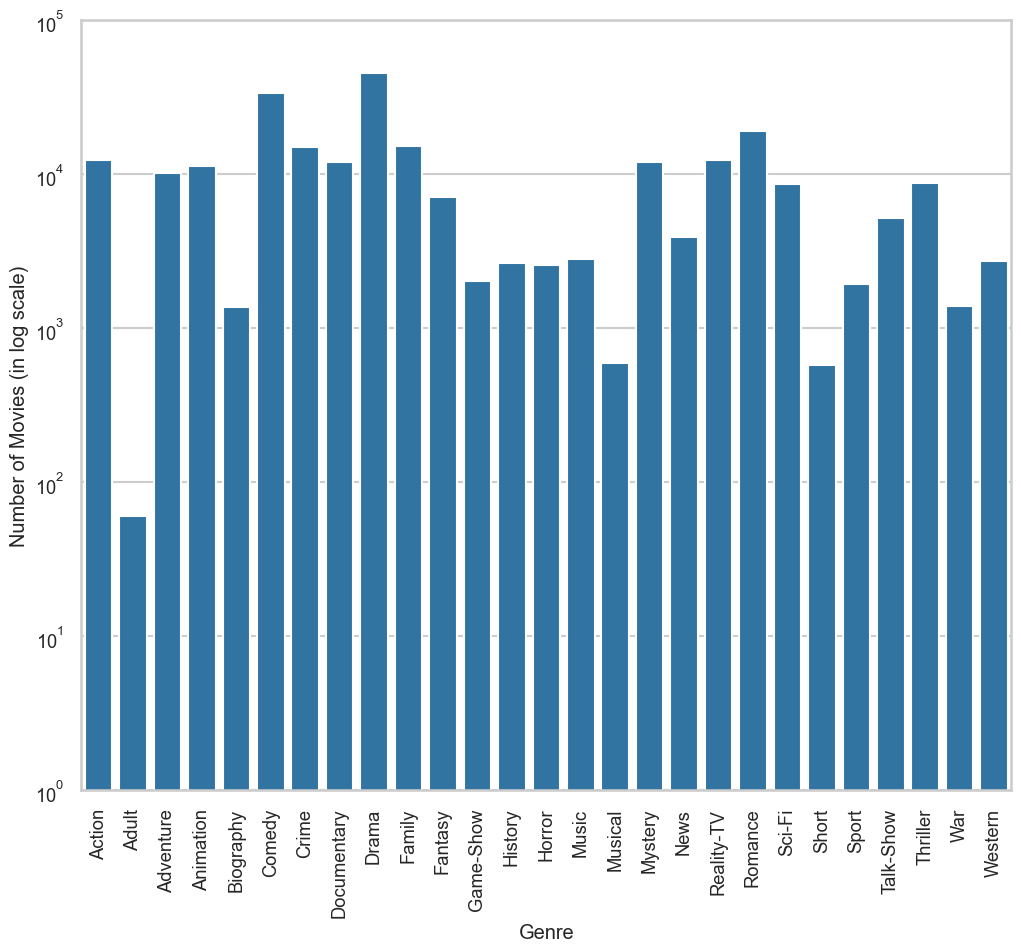

In [30]:
f, ax = plt.subplots(1, 1, figsize=(12, 10))
sns.barplot(data=df_movies_per_genre, x='Genre', y='Total', axes=ax)
ax.set(yscale='log', ylim=(1, 1e5), ylabel='Number of Movies (in log scale)')
plt.xticks(rotation=90)
plt.show()

**Observations**  
* Lowest Genre movies is Adult (only 61 movies)
* Highest Genre movies is Drama (45891 movies), followed by Comedy (33870)

## Number of Genres per Movie

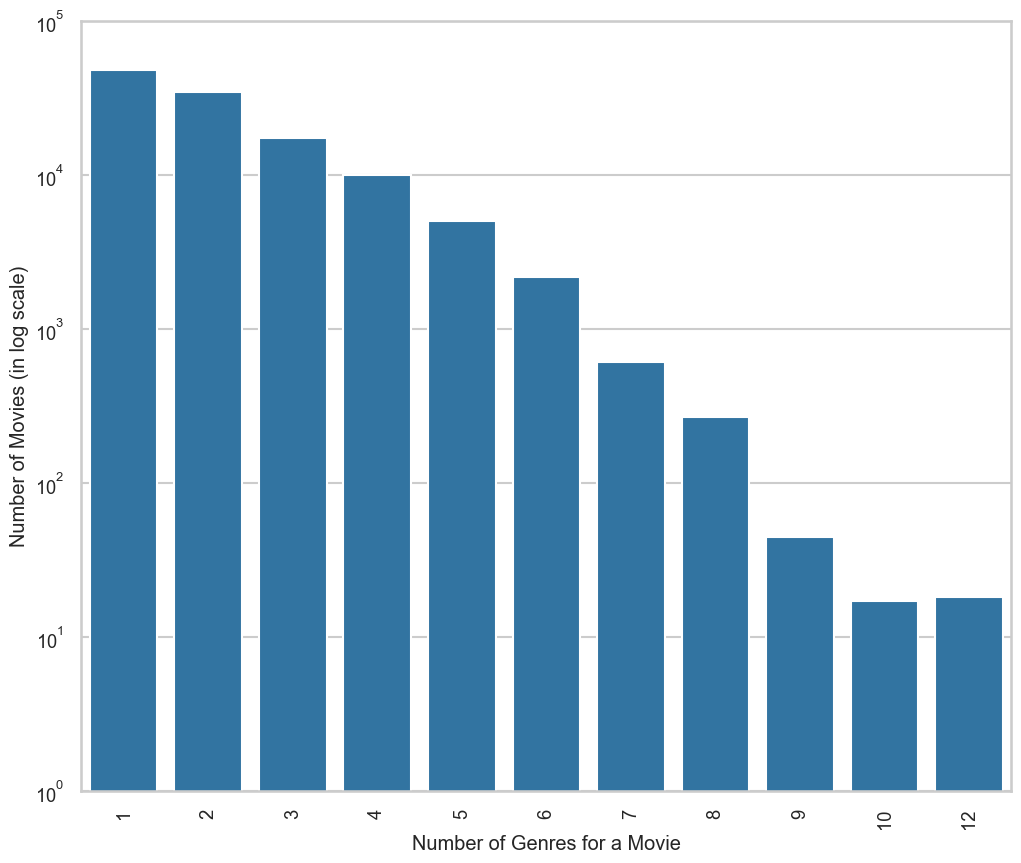

In [33]:

sum_movie = mydata[category_columns].apply(lambda x: x.cat.codes if x.dtype.name == 'category' else pd.to_numeric(x, errors='coerce')).sum(axis=1)

df_genres_per_movie = pd.DataFrame({'title': mydata['title'], 'num_genres': sum_movie}).groupby('num_genres').count()

f, ax = plt.subplots(1, 1, figsize=(12, 10))
sns.barplot(data=df_genres_per_movie.reset_index(), x='num_genres', y='title', ax=ax)
ax.set(yscale='log', ylim=(1, 1e5), xlabel='Number of Genres for a Movie', ylabel='Number of Movies (in log scale)')
plt.xticks(rotation=90)
plt.show()


In [34]:
print('On an average, movies are classified into {0:.2f} genres'.format(sum_movie.mean()))
print('Number of movies with 12 genres = {0}'.format(len(sum_movie[sum_movie==12])))

On an average, movies are classified into 2.15 genres
Number of movies with 12 genres = 18


## Data Preprocessing
Here we clean up our data (plot of the movie) by using the below preprocessing techniques
* Removing any html tags
* Removing punctuations
* Removing any accented characters
* Keeping only Alphabetic strings
* Removing 'english' stop words
* Stemming
* Lower Casing all the words

### Removing HTML tags

In [35]:
def remove_tags(sentence):
    html_tag = '<.*?>'
    cleaned_sentence = re.sub(html_tag, ' ',  sentence)
    return cleaned_sentence

In [36]:
print(remove_tags('<html><h2>Learning NLP</h2></html>'))
print(remove_tags(' <a>Movie-Plot</a>'))

  Learning NLP  
  Movie-Plot 


### Removing Accented Characters

In [37]:
def remove_accents(sentence):
    cleaned_sentence = unicodedata.normalize('NFD', sentence)
    cleaned_sentence = cleaned_sentence.encode('ascii', 'ignore')
    cleaned_sentence = cleaned_sentence.decode("utf-8")
    return cleaned_sentence

### Remove Punctuations

In [38]:
def remove_punctuation(sentence):
    cleaned_sentence = re.sub(r'[?|!|\'|"|#]', '', sentence)
    cleaned_sentence = re.sub(r'[,|.|;|:|(|)|{|}|\|/|<|>]|-', ' ', cleaned_sentence)
    cleaned_sentence = cleaned_sentence.replace("\n"," ")
    return cleaned_sentence

### Keeping only Alphabetic strings

In [39]:
def keep_alpha(sentence):
    alpha_sentence = re.sub('[^a-z A-Z]+', ' ', sentence)
    return alpha_sentence

### Lower Case
Converting all the text into lower case

In [40]:
def lower_case(sentence):
    lower_case_sentence = sentence.lower()
    return lower_case_sentence

### Stemming

In [41]:
def stemming(sentence):
    stemmer = SnowballStemmer("english")
    stemmed_words = [stemmer.stem(word) for word in sentence.split()]
    stemmed_sentence=' '.join(stemmed_words)
    return stemmed_sentence

### Lemmatize

In [42]:
def lemmatize_words(sentence):
    lem = WordNetLemmatizer()
    lemmatized_words = [lem.lemmatize(word, 'v') for word in sentence.split()]
    lemmatized_sentence=' '.join(lemmatized_words)
    return lemmatized_sentence

### Stop Words

In [43]:
def remove_stop_words(sentence):
    stop_words = set(stopwords.words('english'))
    stop_words.update(['zero','one','two','three','four','five','six','seven','eight','nine','ten',
                       'may','also','across','among','beside','however','yet','within'])
    no_stop_words=[word for word in sentence.split() if word not in stop_words]
    no_step_sentence = ' '.join(no_stop_words)
    return no_step_sentence

In [44]:
def text_preprocess(sentence):
    pre_processed_sentence = remove_tags(sentence)
    pre_processed_sentence = remove_accents(pre_processed_sentence)
    pre_processed_sentence = remove_punctuation(pre_processed_sentence)
    pre_processed_sentence = keep_alpha(pre_processed_sentence)
    pre_processed_sentence = lower_case(pre_processed_sentence)
    #pre_processed_sentence = stemming(pre_processed_sentence) # Use Lemmatize instead of stemming
    pre_processed_sentence = lemmatize_words(pre_processed_sentence)
    pre_processed_sentence = remove_stop_words(pre_processed_sentence)
    
    return pre_processed_sentence

In [45]:
if not preprocessed_data:
    mydata['plot'] = mydata['plot'].apply(text_preprocess)
    mydata.to_csv('./Data/preprocessed/movies_genres_preprocessed.csv', index=False)

## Feature Engineering

### plot_lang column

In [46]:
mydata.plot_lang.describe()

count     117194
unique         1
top           en
freq      117194
Name: plot_lang, dtype: object

From the above, we see that all the movies provided have plots in english language. Hence, let us drop this column

In [47]:
mydata = mydata.drop('plot_lang', axis=1)

## Word Cloud Plots
Let us see what are the common words used for each of the movie genre plots

In [48]:
def save_wordcloud_plots(data, labels):
    for idx, col in enumerate(labels):
        wordcloud = WordCloud(max_font_size=50).generate(' '.join(data[data[col]==1]['plot']))
        ax = plt.figure(figsize=(9, 9)).add_subplot(1, 1, 1)
        ax.imshow(wordcloud)
        ax.axis("off")
        ax.set(title='Movie Genre: {0}'.format(col))
        plt.savefig('./Images/results/wordcloud_{0}.png'.format(col), bbox_inches='tight')
        plt.close()
        
def save_wordcloud_subplots(data, labels):
    num_plot = 3
    fig_per_plot = 10 #math.ceil(len(category_columns)/num_plot)
    num_cols = 2
    num_rows = math.ceil(fig_per_plot/num_cols)
    for idx, col in enumerate(category_columns):
        if idx%fig_per_plot==0:
            fig = plt.figure(figsize=(14, 20))
        wordcloud = WordCloud(max_font_size=50).generate(' '.join(mydata[mydata[col]==1]['plot']))
        ax = fig.add_subplot(num_rows, num_cols, idx%fig_per_plot+1)
        ax.imshow(wordcloud)
        ax.axis("off")
        ax.set(title='Movie Genre: {0}'.format(col))
        if (idx+1)%fig_per_plot==0 or idx==len(category_columns)-1:
            plt.savefig('./Images/results/wordcloud_part{0}.png'.format(1+idx//fig_per_plot), bbox_inches='tight')
            plt.close()
            fig = plt.figure(figsize=(14, 20))

In [49]:
if not os.path.exists('Images/results/wordcloud_Action.png'):
    save_wordcloud_plots(mydata, category_columns)
if not os.path.exists('Images/results/wordcloud_part1.png'):
    save_wordcloud_subplots(mydata, category_columns)

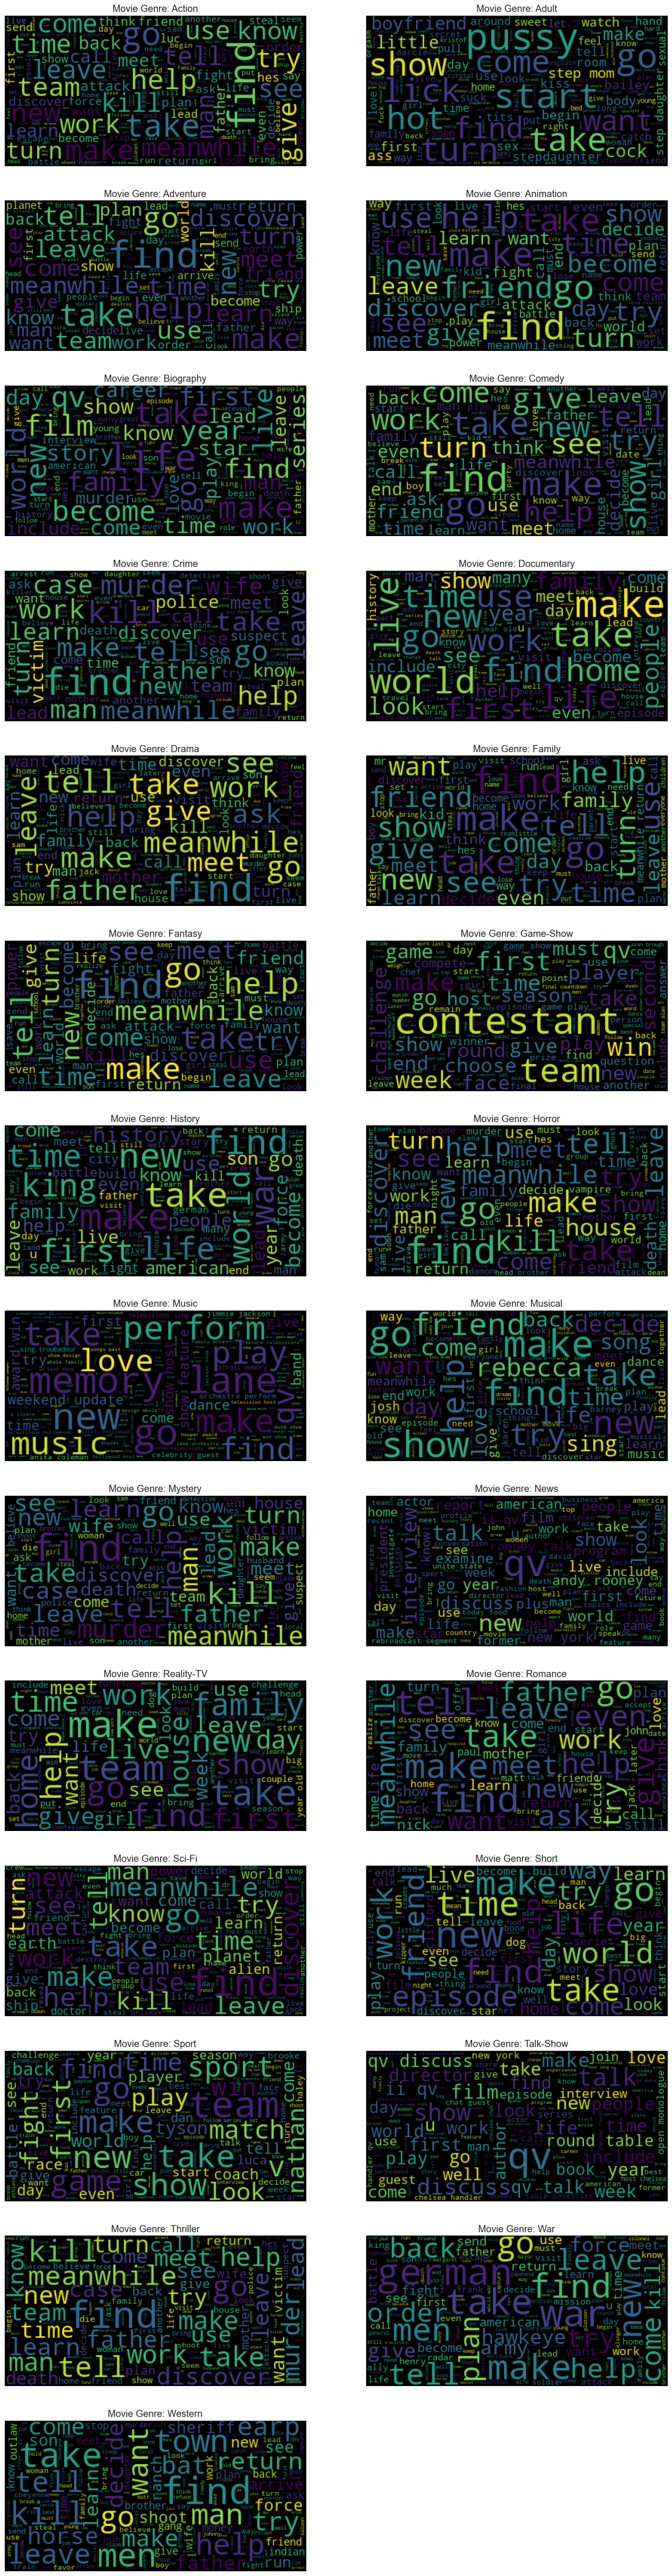

In [50]:
fig = plt.figure(figsize=(18, 70))
num_cols = 2
num_rows = math.ceil(len(category_columns)/num_cols)
for idx, col in enumerate(category_columns):
    wordcloud = WordCloud(max_font_size=50).generate(' '.join(mydata[mydata[col]==1]['plot']))
    ax = fig.add_subplot(num_rows, num_cols, idx+1)
    ax.imshow(wordcloud)
    ax.axis("off")
    ax.set(title='Movie Genre: {0}'.format(col))
plt.show()

**Observations**  
* `qv` is generally used as a tag to indicate a persons name when he appears in a movie as himself. Hence we see `qv` show up as an important feature in News, Game-Show, Biography and Talk-Show Genres. 
* `german` an important feature for War based Genre
* Few obvious key words include: `attack` for Action, `discover` for Adventure, `life, career` for Biography, `kill, murder` for Crime, Mystery and Thriller, `challenge, contestant, round` for Game-Shows, `perform, band` for Music, `vs, win, team` for Sports, `horse, sheriff` for Western. 

## Genre Correlation Analysis
Now let us see what genres are mostly correlated. In other words, if a movie is for example Action, what are the other Genres it can fall under

### Heatmap Plot

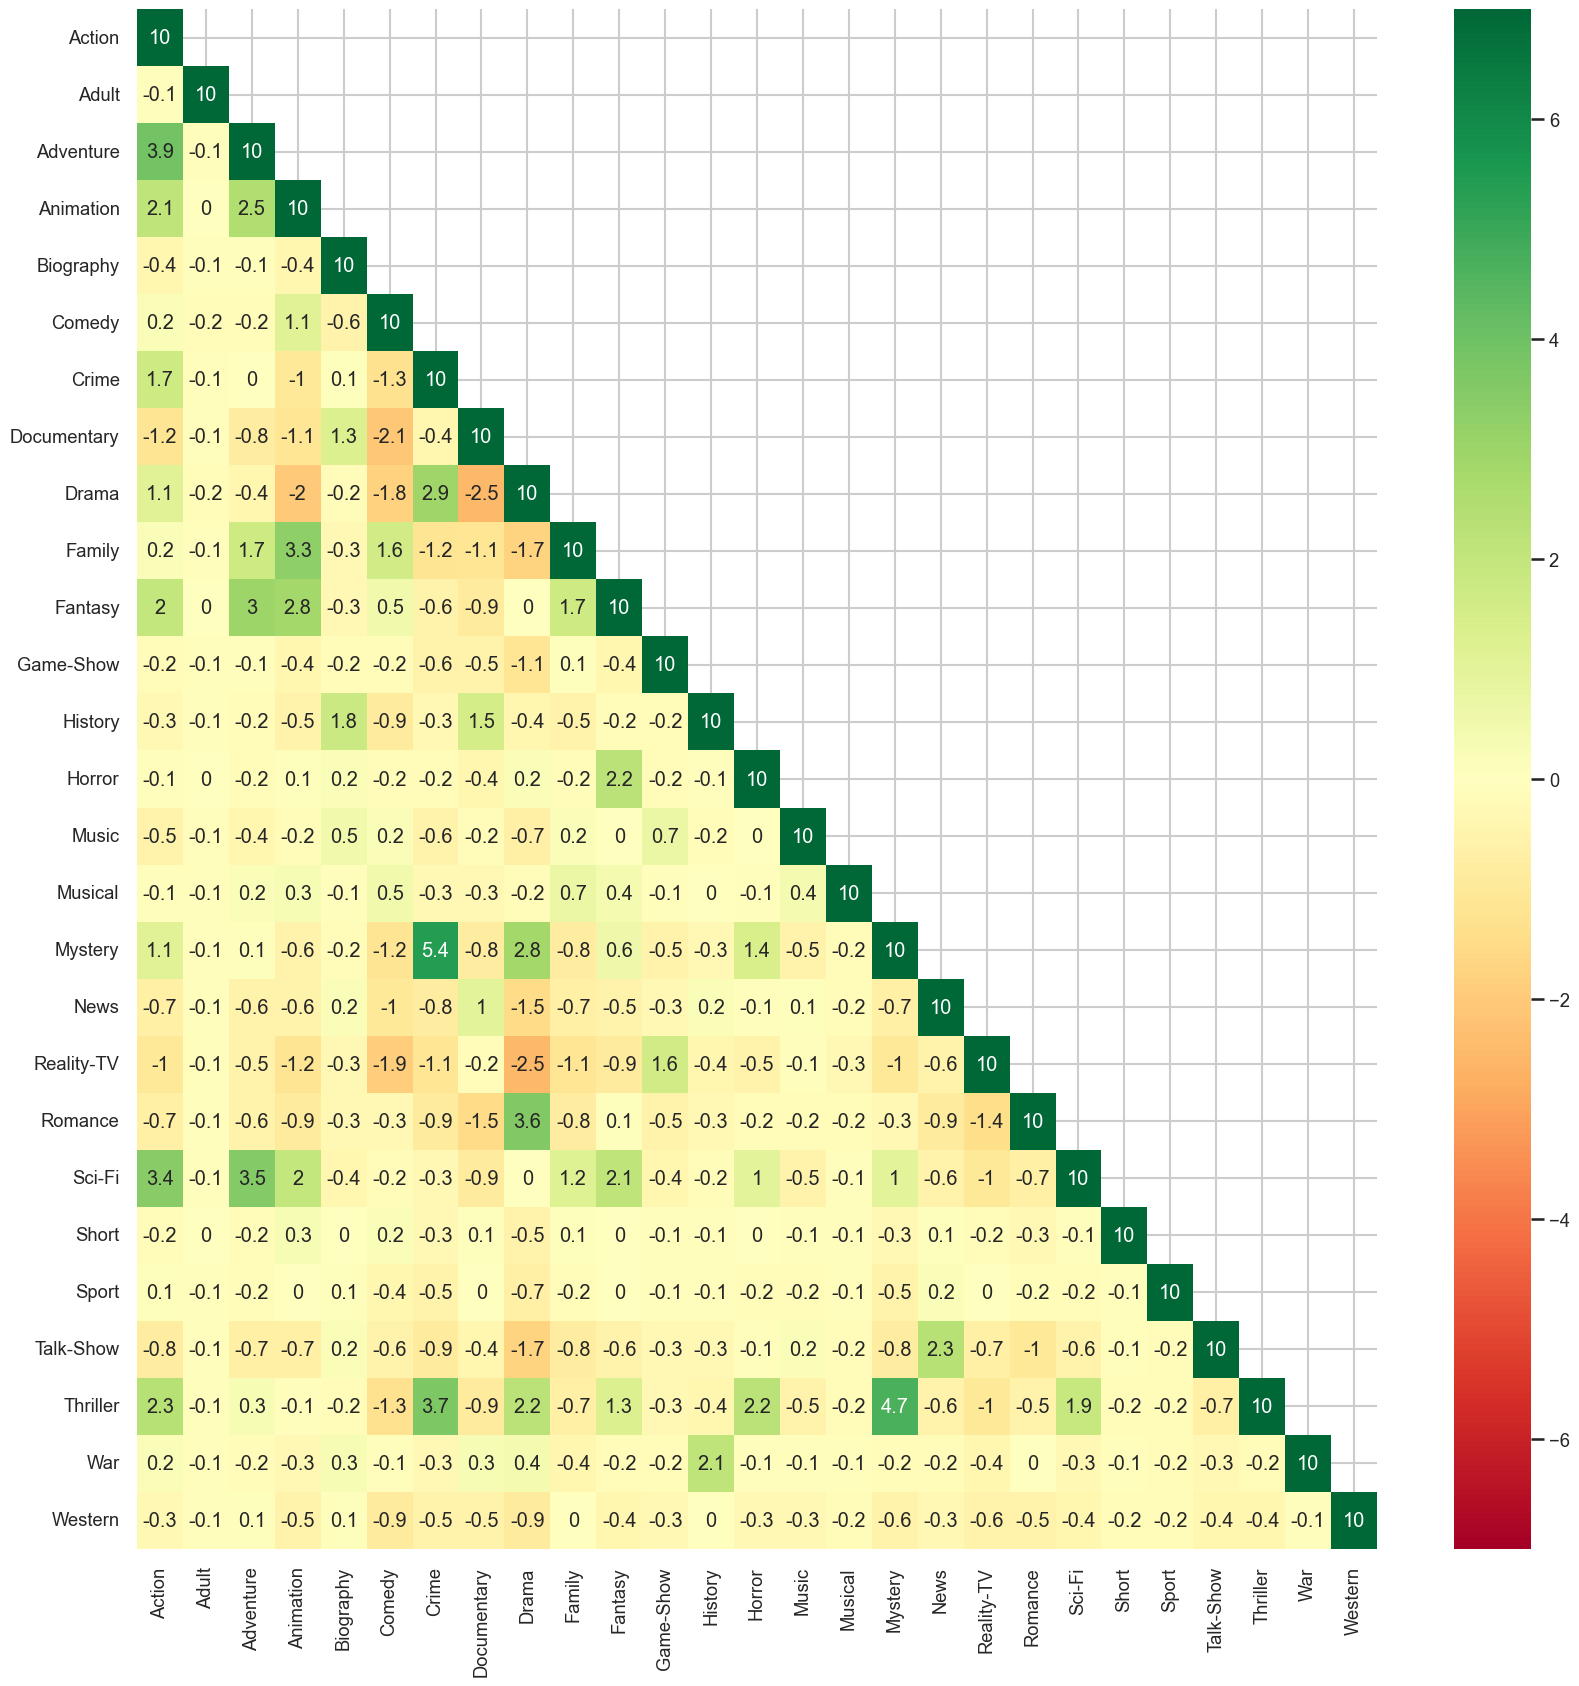

In [51]:
# Heatmap relative to all numeric columns
corr_matrix = (mydata[category_columns].astype('int')).corr()
mask = np.array(corr_matrix)
mask[np.tril_indices_from(mask)] = False
corr_matrix = (100*corr_matrix//1)/10

fig = plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, mask=mask, annot=True, cbar=True, vmax=7, vmin=-7, cmap='RdYlGn')
plt.show()

**Observations**  
* The below Genre categories show strong positive correlation with each other
    * Action, Adventure and Sci-Fi
    * Animation, Fantasy and Family
    * Crime, Thriller, Mystery and Drama
    * Biography, Documentry and History
    * Drama and Romance
    * Game-show and Reality-TV
    * Horror, Thriller and Fantasy
    * Talk-show and News
    * War and History
* The below Genre categories show strong negative correlation with each other
    * Animation and Drama
    * Comedy with Documentary and Reality-TV
    * Documentary with Comedy, Drama and Romance
    * Drama with Animation, Reality-TV and Comedy

### Multi-Genre Distribution Plots
Now let us see if a movie belongs to a certain Genre, what are the other Genres it might fall under

In [52]:
def save_genre_pdf_given_genre_plots(data, labels):
    for idx, col in enumerate(labels):
        df_sum_given_genre = pd.DataFrame({'Genre':labels, 'Total': data[data[col]==1][labels].sum()})
        df_sum_given_genre = df_sum_given_genre.sort_values('Total', ascending=False).head(10)
        df_sum_given_genre['Total'] = df_sum_given_genre['Total']/df_sum_given_genre['Total'].max()
        ax = plt.figure(figsize=(9, 9)).add_subplot(1, 1, 1)
        sns.barplot(data=df_sum_given_genre, x='Genre', y='Total', axes=ax)
        ax.set(title='Distribution given {0} Genre'.format(col), xlabel='', ylabel='Normalized Number of Movies')
        plt.xticks(rotation=90)
        plt.savefig('./Images/results/genre_pdf_given_{0}.png'.format(col), bbox_inches='tight')
        plt.close()
        
def save_genre_pdf_given_genre_subplots(data, labels):
    num_plot = 3
    fig_per_plot = math.ceil(len(category_columns)/num_plot)
    num_cols = 3
    num_rows = math.ceil(fig_per_plot/num_cols)
    for idx, col in enumerate(category_columns):
        if idx%fig_per_plot==0:
            fig = plt.figure(figsize=(20, 30))
        df_sum_given_genre = pd.DataFrame({'Genre':labels, 'Total': data[data[col]==1][labels].sum()})
        df_sum_given_genre = df_sum_given_genre.sort_values('Total', ascending=False).head(10)
        df_sum_given_genre['Total'] = df_sum_given_genre['Total']/df_sum_given_genre['Total'].max()
        ax = fig.add_subplot(num_rows, num_cols, idx%fig_per_plot+1)
        sns.barplot(data=df_sum_given_genre, x='Genre', y='Total', axes=ax)
        ax.set(title='Distribution given {0} Genre'.format(col), xlabel='', ylabel='Normalized Number of Movies')
        plt.xticks(rotation=90)
        if (idx+1)%fig_per_plot==0 or idx==len(category_columns)-1:
            plt.savefig('./Images/results/genre_pdf_part{0}.png'.format(1+idx//fig_per_plot), bbox_inches='tight')
            plt.close()
            fig = plt.figure(figsize=(20, 30))

In [53]:
if not os.path.exists('Images/results/genre_pdf_given_Action.png'):
    save_genre_pdf_given_genre_plots(mydata, category_columns)
if not os.path.exists('Images/results/genre_pdf_part1.png'):
    save_genre_pdf_given_genre_subplots(mydata, category_columns)

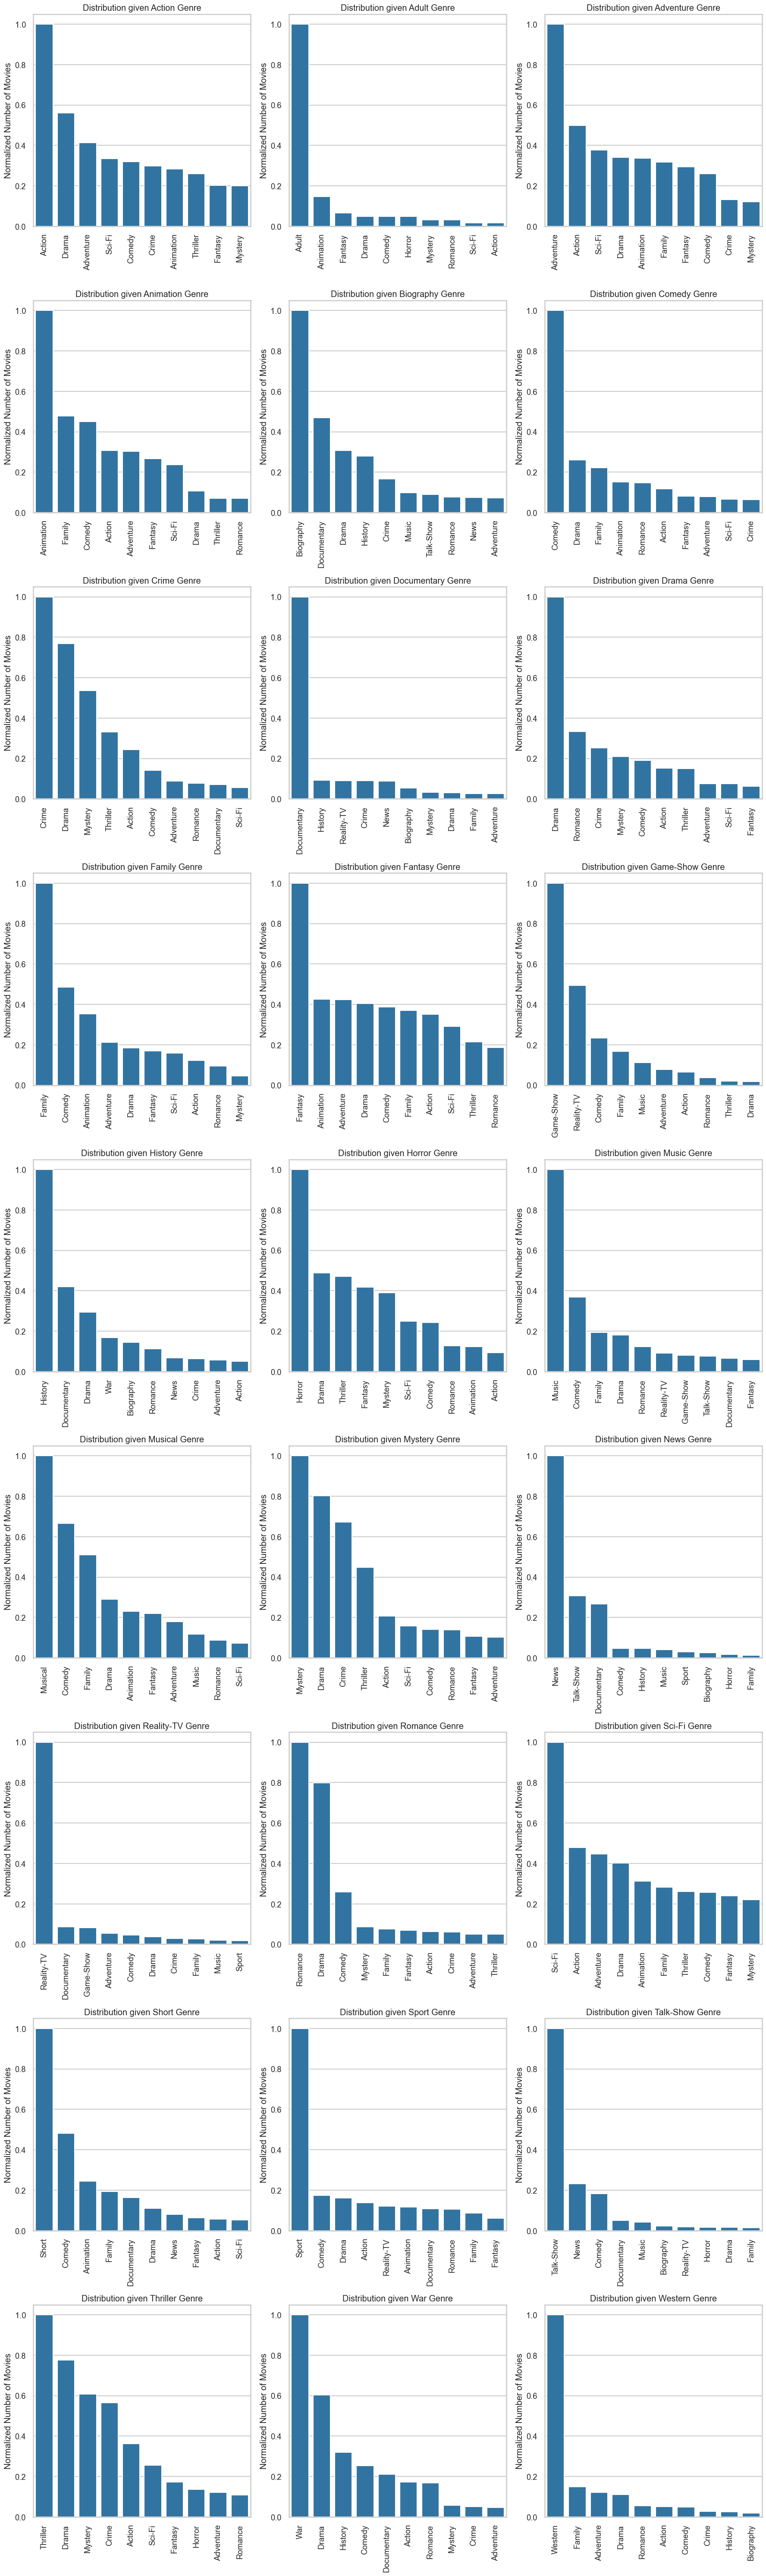

In [67]:
fig = plt.figure(figsize=(18, 60))
num_cols = 3
num_rows = math.ceil(len(category_columns) / num_cols)

for idx, col in enumerate(category_columns):
    # Convert categorical columns to numeric type before summing
    mydata_numeric = mydata[category_columns].apply(lambda x: pd.to_numeric(x, errors='coerce') if x.dtype.name == 'category' else x)
    
    # Create the DataFrame for the given genre
    df_sum_given_genre = pd.DataFrame({
        'Genre': category_columns,
        'Total': mydata_numeric[mydata[col] == 1][category_columns].sum()
    })
    
    df_sum_given_genre = df_sum_given_genre.sort_values('Total', ascending=False).head(10)
    df_sum_given_genre['Total'] = df_sum_given_genre['Total'] / df_sum_given_genre['Total'].max()
    
    ax = fig.add_subplot(num_rows, num_cols, idx + 1)
    sns.barplot(data=df_sum_given_genre, x='Genre', y='Total', ax=ax)
    ax.set(title='Distribution given {0} Genre'.format(col), xlabel='', ylabel='Normalized Number of Movies')
    plt.xticks(rotation=90)

plt.tight_layout()
plt.show()


**Observations**  
* More than half of Action movies also fall in Drama genre
* Almost 50% of the Animation movies are also categorized as Family or Comedy
* 80% of the Crime, Mystery, Thriller and Romance movies are also categorized as Drama
* Half of the Game-Shows are also categorized as Reality TV
* 65% of Musical movies are Comedy
* 50% of Short movies are Comedy
* 60% of War movies are also Drama

### Number of Genres given a Genre

In [68]:
def save_numGenre_pdf_given_genre_plots(data, labels):
    for idx, col in enumerate(labels):
        df_genres_per_movie = pd.DataFrame({'Total': data[data[col]==1][labels].sum(axis=1)})
        df_numG_given_genre = pd.DataFrame(df_genres_per_movie['Total'].value_counts().sort_index().head(10))
        df_numG_given_genre['Total'] = df_numG_given_genre['Total']/df_numG_given_genre['Total'].max()
        ax = plt.figure(figsize=(9, 9)).add_subplot(1, 1, 1)
        sns.barplot(data=df_numG_given_genre, x=df_numG_given_genre.index, y='Total', axes=ax)
        ax.set(title='Number of Genres distribution given {0} Genre'.format(col), xlabel='', ylabel='Normalized Number of Movies')
        plt.savefig('./Images/results/numGenre_pdf_given_{0}.png'.format(col), bbox_inches='tight')
        plt.close()
        
def save_numGenre_pdf_given_genre_subplots(data, labels):
    num_plot = 3
    fig_per_plot = math.ceil(len(category_columns)/num_plot)
    num_cols = 3
    num_rows = math.ceil(fig_per_plot/num_cols)
    for idx, col in enumerate(category_columns):
        if idx%fig_per_plot==0:
            fig = plt.figure(figsize=(20, 30))
        df_genres_per_movie = pd.DataFrame({'Total': data[data[col]==1][labels].sum(axis=1)})
        df_numG_given_genre = pd.DataFrame(df_genres_per_movie['Total'].value_counts().sort_index().head(10))
        df_numG_given_genre['Total'] = df_numG_given_genre['Total']/df_numG_given_genre['Total'].max()
        ax = fig.add_subplot(num_rows, num_cols, idx%fig_per_plot+1)
        sns.barplot(data=df_numG_given_genre, x=df_numG_given_genre.index, y='Total', axes=ax)
        ax.set(title='Number of Genres distribution given {0} Genre'.format(col), xlabel='', ylabel='Normalized Number of Movies')
        if (idx+1)%fig_per_plot==0 or idx==len(category_columns)-1:
            plt.savefig('./Images/results/numGenre_pdf_part{0}.png'.format(1+idx//fig_per_plot), bbox_inches='tight')
            plt.close()
            fig = plt.figure(figsize=(20, 30))

In [69]:
if not os.path.exists('Images/results/numGenre_pdf_given_Action.png'):
    save_numGenre_pdf_given_genre_plots(mydata, category_columns)
if not os.path.exists('Images/results/numGenre_pdf_part1.png'):
    save_numGenre_pdf_given_genre_subplots(mydata, category_columns)

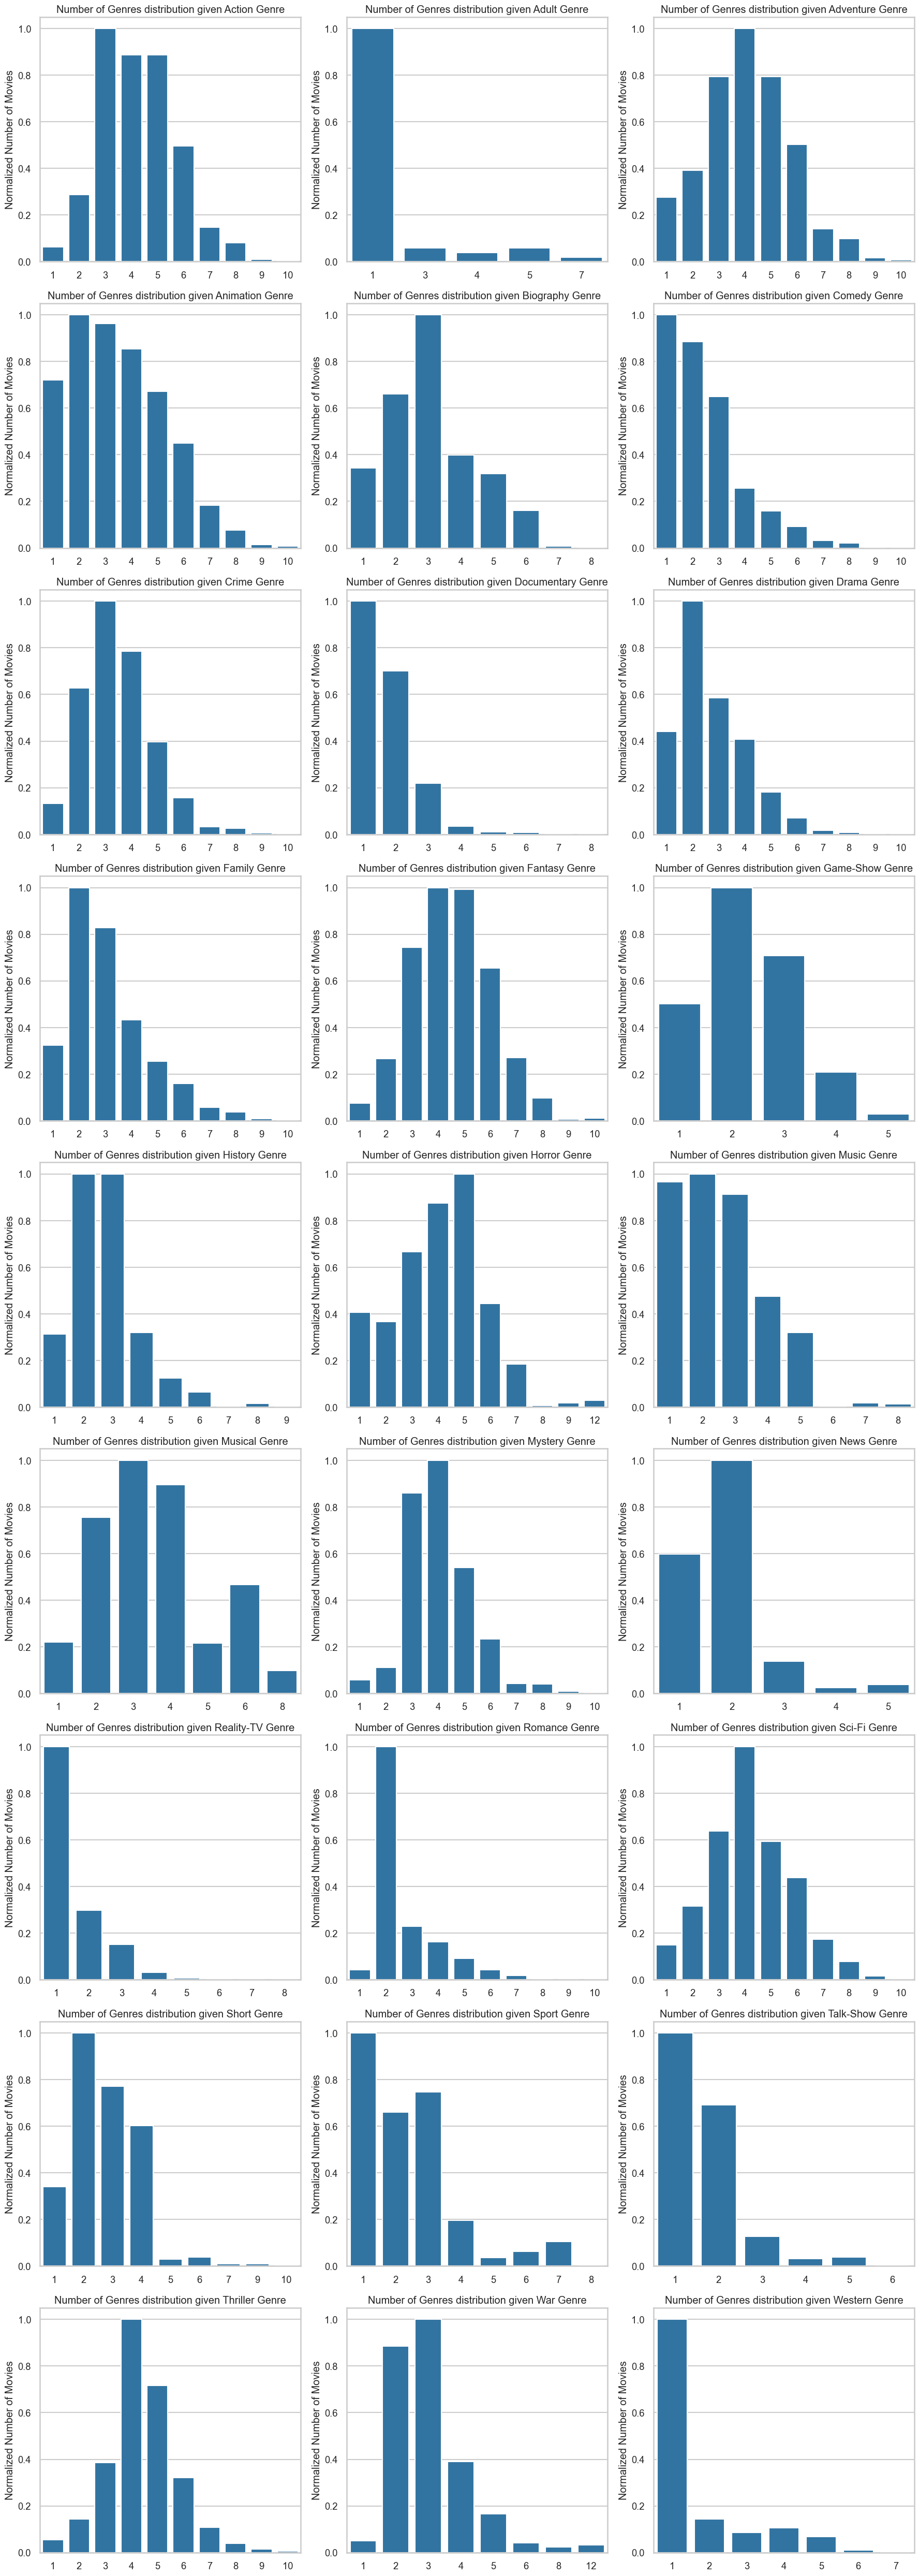

In [74]:
fig = plt.figure(figsize=(18, 50))
num_cols = 3
num_rows = math.ceil(len(category_columns) / num_cols)

for idx, col in enumerate(category_columns):
    # Convert category columns to integers or numeric
    mydata_numeric = mydata[category_columns].apply(lambda x: pd.to_numeric(x, errors='coerce') if x.dtype.name == 'category' else x)

    # Sum across the rows for the specified condition
    df_genres_per_movie = pd.DataFrame({'Total': mydata_numeric[mydata_numeric[col] == 1][category_columns].sum(axis=1)})

    # Get the count of the number of genres per movie and normalize
    df_numG_given_genre = df_genres_per_movie['Total'].value_counts().sort_index().head(10).reset_index()
    df_numG_given_genre.columns = ['Number of Genres', 'Total']
    df_numG_given_genre['Total'] = df_numG_given_genre['Total'] / df_numG_given_genre['Total'].max()

    # Create the plot
    ax = fig.add_subplot(num_rows, num_cols, idx + 1)
    sns.barplot(data=df_numG_given_genre, x='Number of Genres', y='Total', ax=ax)
    ax.set(title='Number of Genres distribution given {0} Genre'.format(col), xlabel='', ylabel='Normalized Number of Movies')

plt.tight_layout()
plt.show()


**Observations**  
* Most of the Action, Adventure, Animation, Fantasy, Horror, Mystery, Sci-Fi and Thriller movies have 3 to 6 categories
* Most of the Adult, Documentry, Reality-TV, Talk-Show and Western movies have just a single label

# MODELING

## Test-Train Split
Now let us first split the provided data into a train and test sets. This is a multi-label data set with highly imbalanced labels (Adult having just 61 samples and Drama with >45000 samples). In the below function `multi_label_train_test_split`, we split the provided data set ensuring that both the data sets have a minimum fraction of every labels. The minimum fraction is provided as an input parameter. We loop through each category and include `min_test_size` fraction of that category into the test data set. Clearly at the end of the loop, the number of occurence of each category will be greater than the `min_test_size` fraction since most movies that are being included into the test set as a particular genre also are categorized with other genres. 

We can further optimize the below function to ensure that more even distribution of movies into train and test data set; however, that is not really the aim of this project. Hence we will just stick to this simplified version. 

In [75]:
def multi_label_train_test_split(data, labels, min_test_size=0.15, shuffle=True, random_state=29):
    data_size = data.shape[0]
    
    # data_test_idx holds the test indices corresponding to the original data DataFrame
    data_test_idx = np.array([False]*data_size)
    
    n_folds = math.floor(1/min_test_size)
    data_train, data_test = pd.DataFrame(), pd.DataFrame()
    for col in labels:
        # Extracting the current genre plots
        data_curr_genre = data[data[col]==1]
        
        curr_genre_size = data_curr_genre.shape[0]
        curr_test_size = math.ceil(curr_genre_size*min_test_size)
        
        # Using KFold to get the test_idx for the current genre
        curr_genre_test_idx = np.array([False]*curr_genre_size)
        kf = KFold(curr_genre_size, n_folds=n_folds, shuffle=shuffle, random_state=random_state)
        # Using the first fold values for the test indices for the current genre
        curr_genre_test_idx[kf.idxs[0:curr_test_size]]=True
        
        # Mapping the test indices in the data_curr_genre back to the original data DataFrame
        data_test_idx[data_curr_genre[curr_genre_test_idx].index]=True
    
    data_test = data[data_test_idx]
    data_train = data[~data_test_idx]
    return data_train, data_test

**Preprocessing the training and testing data sets separately**

In [76]:
if os.path.exists('Data/preprocessed/movies_genres_train_preprocessed.csv') and os.path.exists('Data/preprocessed/movies_genres_test_preprocessed.csv'):
    mydata_train = pd.read_csv('Data/preprocessed/movies_genres_train_preprocessed.csv')
    mydata_test = pd.read_csv('Data/preprocessed/movies_genres_test_preprocessed.csv')
else:
    mydata_raw = pd.read_csv('Data/movies_genres.csv', delimiter='\t')
    min_test_size = 0.185
    mydata_train, mydata_test = multi_label_train_test_split(mydata_raw, category_columns, min_test_size=min_test_size)
    
    mydata_train['plot'] = mydata_train['plot'].apply(text_preprocess)
    mydata_train.to_csv('./Data/preprocessed/movies_genres_train_preprocessed.csv', index=False)
    
    mydata_test['plot'] = mydata_test['plot'].apply(text_preprocess)
    mydata_test.to_csv('./Data/preprocessed/movies_genres_test_preprocessed.csv', index=False)

### Checking Trian-Test Composition

Let us check the composition of train and test data set to ensure each label occur with reasonable fraction in both these data sets. The test dataset considered has ~0.2 of the entire dataset. 

In [77]:
print('Fraction of data in the Training Data Set: {0:.3f}'.format(mydata_test.shape[0]/mydata.shape[0]))

Fraction of data in the Training Data Set: 0.195


Looking at each of the datasets to see how many movies of each genres are present

In [82]:
# Convert categorical to numeric (if they represent boolean or numeric-like categories)
sum_genre = mydata[category_columns].astype(int).sum()
sum_genre_train = mydata_train[category_columns].astype(int).sum()
sum_genre_test = mydata_test[category_columns].astype(int).sum()

# Creating dataframes for train and test
df_movies_per_genre_1 = pd.DataFrame({'Genre': category_columns, 'Total': sum_genre_train / sum_genre, 'Data Set': 'Train'})
df_movies_per_genre_2 = pd.DataFrame({'Genre': category_columns, 'Total': sum_genre_test / sum_genre, 'Data Set': 'Test'})

# Concatenate the dataframes
df_movies_per_genre = pd.concat([df_movies_per_genre_1, df_movies_per_genre_2])


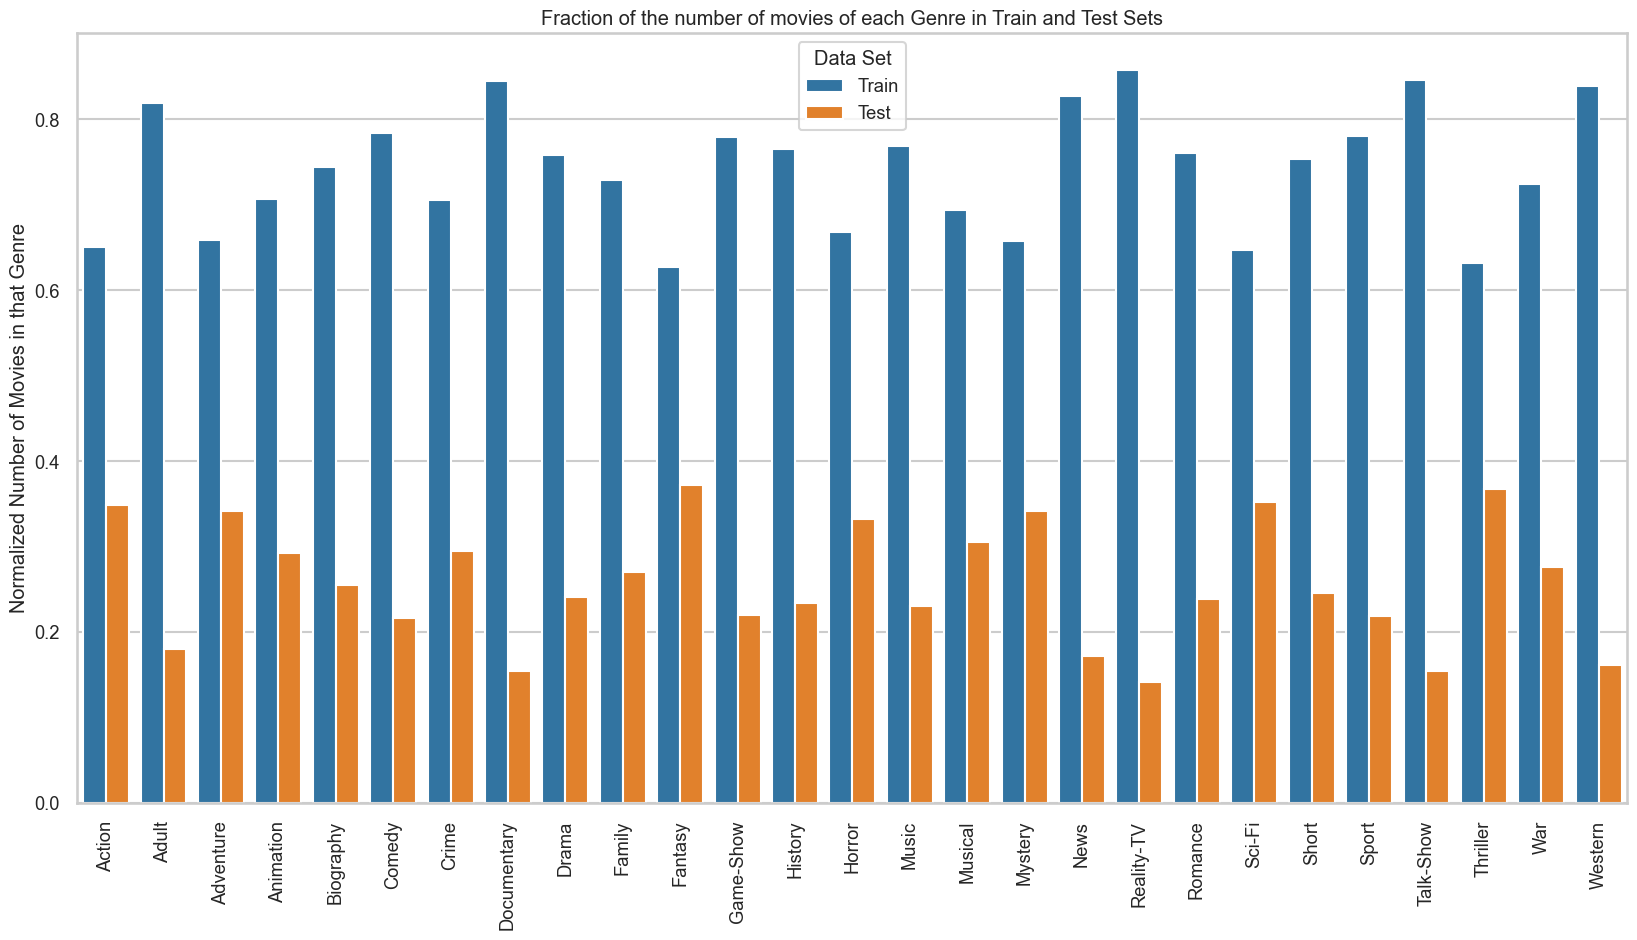

In [84]:
f, ax = plt.subplots(1, 1, figsize=(20, 10))
sns.barplot(data=df_movies_per_genre, x='Genre', y='Total', hue='Data Set', axes=ax)
ax.set(ylabel='Normalized Number of Movies in that Genre', xlabel='')
ax.set(title='Fraction of the number of movies of each Genre in Train and Test Sets')
plt.xticks(rotation=90)
plt.show()

**Observations**  
* For every category, we have at least 60% of the samples in the training data set and at least 15% of the samples in the test data set which seems good for our purpose

## Binary Relevance
Refer to the notebook inside Reports/2_Modeling_BinaryRelevance.ipynb

## Label Powerset
Refer to the notebook inside Reports/3_Modeling_LabelPowerset.ipynb

## Sentence Embedding
Refer to the notebook inside Reports/4_Modeling_Embeding_Cosine_Sim.ipynb and Reports/5_Modeling_Embeding_Neural_Net.ipynb

# SUMMARY

In [85]:
algo_score = pd.DataFrame()
algo_score.index.name = 'Modelling Algo'
algo_score['Overall Precision'] = None
algo_score['Overall Recall'] = None
algo_score['Overall F1-Score'] = None

In [86]:
algo_score.loc['BR+CV+SVC'] = [0.86, 0.63, 0.72]
algo_score.loc['BR+TF-IDF+SVC'] = [0.85, 0.72, 0.77]
algo_score.loc['BR+TF-IDF+LR'] = [0.7, 0.79, 0.74]
algo_score.loc['BR+TF-IDF+NB'] = [0.8, 0.73, 0.76]
algo_score.loc['LP+CV+SVC'] = [0.81, 0.76, 0.79]
algo_score.loc['LP+TF-IDF+NB'] = [0.87, 0.54, 0.64]
algo_score.loc['LP+TF-IDF+SVC'] = [0.85, 0.82, 0.83]
algo_score.loc['LPC+TF-IDF+SVC'] = [0.86, 0.61, 0.7]
algo_score.loc['LP+Embed+Cosine'] = [0.57, 0.65, 0.6]
algo_score.loc['LP+Embed+NN'] = [0.77, 0.54, 0.62]
algo_score.loc['BR+Embed+NN'] = [0.64, 0.47, 0.47]

In [87]:
algo_score

Overall Precision  Overall Recall  Overall F1-Score
Modelling Algo                                                      
BR+CV+SVC                     0.86            0.63              0.72
BR+TF-IDF+SVC                 0.85            0.72              0.77
BR+TF-IDF+LR                  0.70            0.79              0.74
BR+TF-IDF+NB                  0.80            0.73              0.76
LP+CV+SVC                     0.81            0.76              0.79
LP+TF-IDF+NB                  0.87            0.54              0.64
LP+TF-IDF+SVC                 0.85            0.82              0.83
LPC+TF-IDF+SVC                0.86            0.61              0.70
LP+Embed+Cosine               0.57            0.65              0.60
LP+Embed+NN                   0.77            0.54              0.62
BR+Embed+NN                   0.64            0.47              0.47

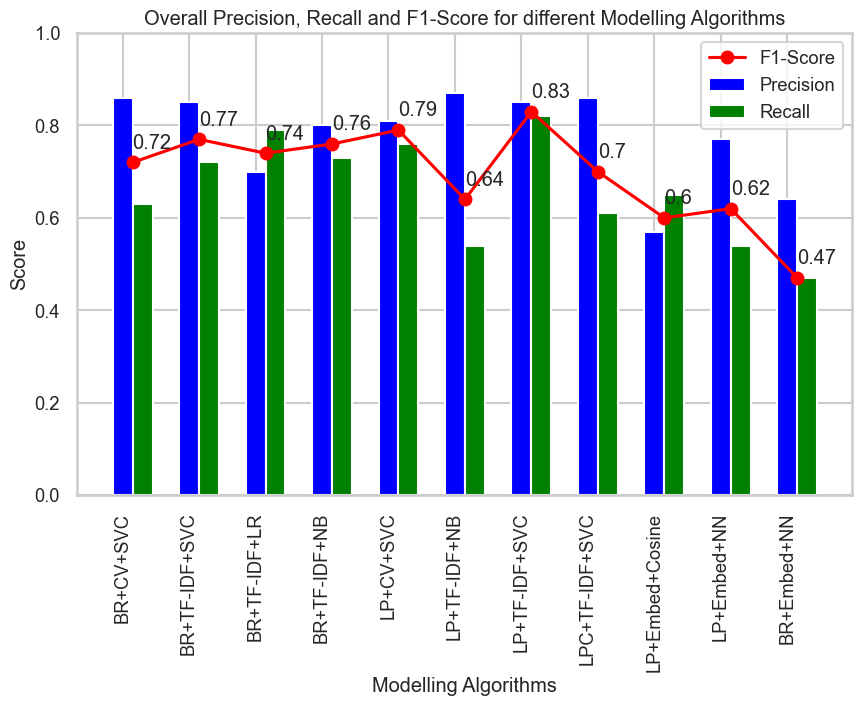

In [88]:
fig=plt.figure(figsize=(10, 6))
axes=fig.add_subplot(1, 1, 1)
bar_width = 0.3
idx = np.array(range(algo_score.shape[0]))
labels = algo_score.index
plt.bar(data=algo_score, height='Overall Precision', x=idx, color='b', width=bar_width, label='Precision')
plt.bar(data=algo_score, height='Overall Recall', x=idx+bar_width, color='g', width=bar_width, label='Recall')
plt.plot(idx+0.15, algo_score['Overall F1-Score'], marker='o', color='r', label='F1-Score')
for i, j in zip(idx, algo_score['Overall F1-Score']): 
    axes.annotate(str(j), xy = (i+0.15, j+0.03))
plt.xticks(idx, labels, rotation=90)
plt.xlabel('Modelling Algorithms')
plt.ylabel('Score')
plt.ylim((0, 1))
plt.title('Overall Precision, Recall and F1-Score for different Modelling Algorithms')
plt.legend()
plt.show()